In [2]:
import pandas as pd
import pickle as pkl

# 데이터 전처리

## Pickle로 데이터 불러오기

In [5]:
with open('../data/bystore.pkl', 'rb') as f:
    data = pkl.load(f)

## 날짜와 시간으로 나누기

In [6]:
# 날짜/시간 데이터 분리
def date_parser(data):
    dates = []
    for d in data:
        a, b = d.split('\n')
        box = [a[:13], a[15], b[:2], b[3:11]]
        dates.append(box)
    return dates

# 데이터 프레임
def df_maker(index):
    columns = ['date', 'day', 'noon', 'time']
    df = pd.DataFrame(date_parser(data[index][0]), columns=columns)
    df['date'] = pd.to_datetime(df['date'])
    return df

In [7]:
df0 = df_maker(0)
df1 = df_maker(1)
df2 = df_maker(2)
df3 = df_maker(3)
df3

,date,day,noon,time
0,2022-06-21,화,오후,10:13:21
1,2022-06-21,화,오후,10:03:40
2,2022-06-21,화,오후,09:54:45
3,2022-06-21,화,오후,09:54:03
4,2022-06-21,화,오후,09:37:27
...,...,...,...,...
1551,2022-03-24,목,오후,05:57:43
1552,2022-03-24,목,오후,02:09:57
1553,2022-03-24,목,오후,12:09:32
1554,2022-03-24,목,오전,11:42:02


# 시각화

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 한글

In [9]:
import platform
import matplotlib
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
if platform.system() == 'Windows':
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
# 맥
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')

## 요일별  주문량

In [10]:
def bar_chart(df, feature, ax, title):
    Mon = df.loc[df['day'] == '월'][feature].value_counts()
    Tue = df.loc[df['day'] == '화'][feature].value_counts()
    Wed = df.loc[df['day'] == '수'][feature].value_counts()
    Thu = df.loc[df['day'] == '목'][feature].value_counts()
    Fri = df.loc[df['day'] == '금'][feature].value_counts()
    Sat = df.loc[df['day'] == '토'][feature].value_counts()
    Sun = df.loc[df['day'] == '일'][feature].value_counts()
    df_sur = pd.DataFrame([Mon, Tue, Wed, Thu, Fri, Sat, Sun], index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    df_sur.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)

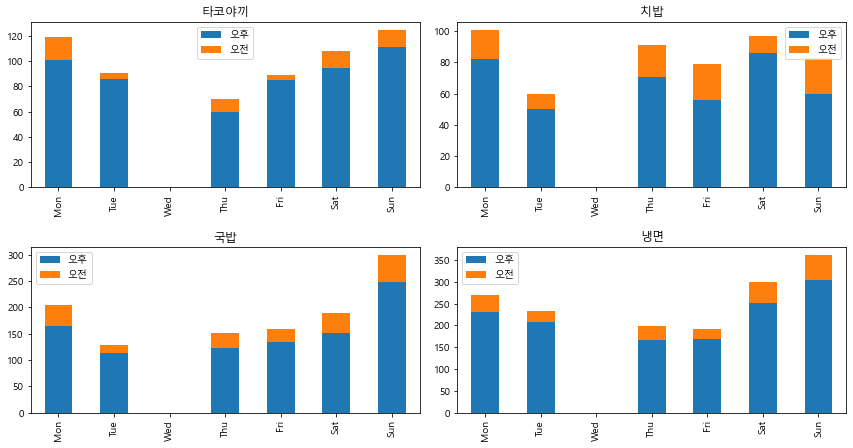

In [11]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 6)
figure.tight_layout(h_pad=4)

bar_chart(df0, 'noon', ax=ax1, title='타코야끼')
bar_chart(df1, 'noon', ax=ax2, title='치밥')
bar_chart(df2, 'noon', ax=ax3, title='국밥')
bar_chart(df3, 'noon', ax=ax4, title='냉면')

__타코야끼, 국밥, 냉면__ 의 경우 주말, 특히 __일요일__ 에 주문량이 많은 것으로 나타났지만 __치밥__ 은 요일의 영향을 크게 받지 않는 것으로 나타났다. 또한, 치밥의 경우 __오전 주문__ 비중이 다른 메뉴에 비해 높게 나타났다. 이는 치밥이 다른 메뉴에 비해 직장인들의 간단한 점심식사로 적합하기 때문으로 추측된다.

## 날짜별 주문량

In [12]:
total = pd.concat([df0, df1, df2, df3], ignore_index = True)
total['month'] = total['date'].dt.month
total['days'] = total['date'].dt.day
total['count'] = 1
group = total.groupby('days')[['count']].sum()
group = group.reset_index()

<AxesSubplot:xlabel='days', ylabel='count'>

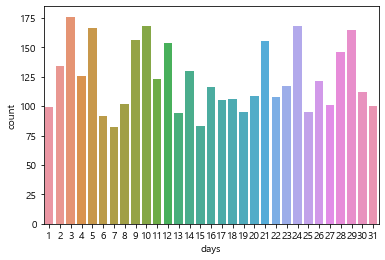

In [13]:
sns.barplot(data=group, x="days", y="count")

## 시간대별 주문량

In [14]:
# 시간 컬럼 추가
total['hour'] = total['time'].apply(lambda x: int(x[:2])+12)
total.loc[(total['noon']=='오전')&(total['hour']==22), 'hour'] = 10
total.loc[(total['noon']=='오전')&(total['hour']==23), 'hour'] = 11
total.loc[(total['noon']=='오후')&(total['hour']==24), 'hour'] = 12

# 주간 컬럼 추가
total['workingday'] = '주간'
total.loc[(total['day'] == '토')|(total['day'] == '일'), 'workingday'] = '주말'

In [15]:
group2 = total.groupby(['hour', 'workingday'])[['count']].sum()
group2 = group2.reset_index()

In [16]:
mean1 = group2.groupby(['workingday']).get_group(name = '주간')
mean1['mean'] = mean1['count']/4
mean2 = group2.groupby(['workingday']).get_group(name = '주말')
mean2['mean'] = mean2['count']/2
mean = pd.concat((mean1, mean2), ignore_index=True)

# 시간대별 전체
mean3 = mean.groupby('hour')[['count']].sum()
mean3['workingday'] = '전체'
mean3['mean'] = mean3['count']/6
mean3 = mean3.reset_index()
mean = pd.concat((mean, mean3), ignore_index=True)
mean

C:\Users\Eugene\AppData\Local\Temp\ipykernel_24616\1790724115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean1['mean'] = mean1['count']/4
C:\Users\Eugene\AppData\Local\Temp\ipykernel_24616\1790724115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean2['mean'] = mean2['count']/2


,hour,workingday,count,mean
0,10,주간,73,18.250000
1,11,주간,265,66.250000
2,12,주간,236,59.000000
3,13,주간,173,43.250000
4,14,주간,112,28.000000
5,15,주간,76,19.000000
6,17,주간,173,43.250000
7,18,주간,283,70.750000
8,19,주간,255,63.750000
9,20,주간,225,56.250000


Text(0.5, 1.0, '시간대별 주문량')

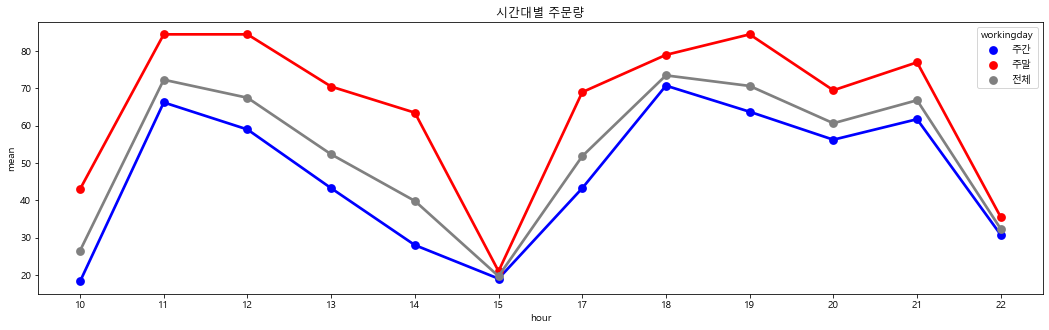

In [17]:
plt.figure(figsize=(18, 5))
pal = sns.color_palette('husl', 3)
sns.pointplot(data=mean, x="hour", y="mean", hue="workingday", palette=['b', 'r', 'grey'])
plt.title('시간대별 주문량')

 시간대별 주문량을 주간/주말로 나누어 시각화해본 결과, __오후 2시~3시 사이__ 가 가장 낮은 주문량을 보여 3시에 브레이크 타임을 갖는 것이 적절한 것으로 판단된다. 또한, 저녁시간대와 더불어 점심시간대 역시 주문량이 많은 것으로 나타났기 때문에 특히 __주간의 11시경__ 에 판매 준비를 철저히 하는 것이 필요하다.

### 각 메뉴의 시간대

In [89]:
def byTime(data, menu):
    data['count'] = 1
    data['Hour'] = data['time'].apply(lambda x: int(x[:2])+12)
    data.loc[(data['noon']=='오전')&(data['Hour']==22), 'Hour'] = 10
    data.loc[(data['noon']=='오전')&(data['Hour']==23), 'Hour'] = 11
    data.loc[(data['noon']=='오후')&(data['Hour']==24), 'Hour'] = 12
    
    df = data.groupby('Hour')[['count']].sum()
    df['mean'] = df['count']/6
    df = df.reset_index()
    df = pd.concat([df, pd.DataFrame({'Hour':[16], 'count':[0], 'mean':[0]})])
    df['menu'] = menu
    return df

Text(0.5, 1.0, '메뉴별 주문 시간대')

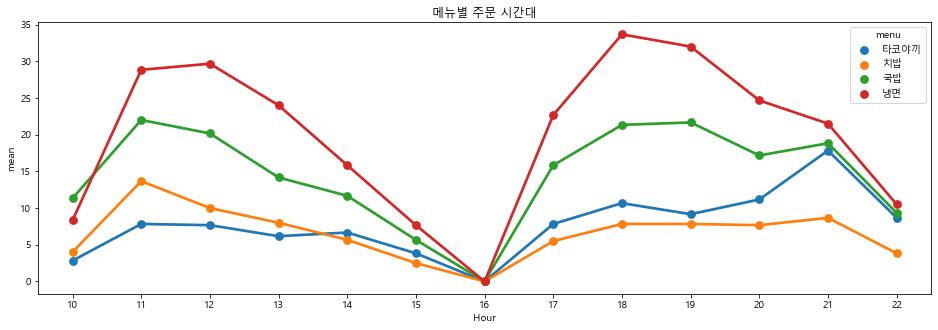

In [92]:
dfs = pd.concat([byTime(df0, '타코야끼'), byTime(df1, '치밥'), byTime(df2, '국밥'), byTime(df3, '냉면')])

plt.figure(figsize=(16, 5))
sns.pointplot(data=dfs, x="Hour", y="mean", hue='menu')
plt.title('메뉴별 주문 시간대')

 각 메뉴의 시간대별 주문량을 알아보기 위해 위와 같이 시각화해본 결과, **냉면과 국밥은 점심(11시 ~ 12시), 저녁(18시 ~ 19시)시간대가 피크타임**이고, **치밥은 점심**, **타코야끼는 야식 시간대인 오후 9시**가 피크 타임인 것으로 나타났다. 또한, 치밥의 11시에서 12시 사이 주문량 변화가 다른 메뉴에 비해 가파른 것은 _직장인들의 일반적인 점심식사 시간이 12시~13시기 때문에 배달 시간을 고려하여 11시에 주문을 한다_ 는 사실에 근거해 `치밥이 직장인들의 점심식사로 선택되고있다`는 가설을 뒷받침 한다.

 따라서 치밥의 판매량을 증가시키기 위해서는 **직장인**과 **점심**이라는 관점에 초점을 맞추어 변화할 필요가 있을 것으로 보인다.